In [1]:
# Librerías

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import cv2

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout, BatchNormalization
from keras.regularizers import l2,l1,L1L2
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.metrics import Precision, SensitivityAtSpecificity, Accuracy
from keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MeanSquaredError

from sklearn.model_selection import train_test_split
import random

## Lectura de información

In [2]:
path = "/kaggle/input/lmn-fetus-tn/dataset"

dir_list = os.listdir(path)
print("Files and directories in '", path, "' :")
# prints all files
print(dir_list)

Files and directories in ' /kaggle/input/lmn-fetus-tn/dataset ' :
['ObjectDetection.xlsx', 'Set1-TrainingValidation Sets CNN', 'External Test Set', 'Internal Test Set', 'Set2-TrainingValidation Sets ANN Scoring system', 'ObjectDetection.csv']


## Funciones para preprocesamiento de las imágenes

Las funciones a continuación tienen el objetivo de eliminar gran cantidad del ruido de una imagen optenida por Ecografía, es decir, llevar a cabo el denoising de la imagen. El algoritmo funciona a través del uso de la Transformada de Fourier de la imagen original, calculando luego su magnitud espectral (MS). La MS de la imagen es utilizada como base para generar máscaras que ocultan el ruido de la señal. El cálculo de esta máscara se basa en la selección de dos umbrales para los valores de la MS: un umbral inferior y un umbral superior. El cálculo automático de estos umbrales está dado por las siguientes ecuaciones:

- Umbral inferior: mean(MS) + alpha*std(MS)
- Umbral superior: max(MS) - beta*std(MS)

Siendo, 'mean' el valor medio de la magnitud espectral, 'std' el desvío estándar de la magnitud espectral, 'alpha' y 'beta' parámetros ajustables, inicialmente de valor 0.5 y 'max' el valor máximo de la magnitud espectral.

La función *lukinoising* lleva a cabo el denoising.

In [3]:
metadata_path = '/ObjectDetection.xlsx'
df_metadata = pd.read_excel(path + metadata_path)

# Convert h_min, w_min, h_max, w_max to integers
for col in ['h_min', 'w_min', 'h_max', 'w_max']:
    df_metadata[col] = df_metadata[col].astype(int)

display(df_metadata)

,fname,structure,h_min,w_min,h_max,w_max
0,168.png,thalami,178,171,244,261
1,168.png,nasal bone,96,308,111,349
2,168.png,palate,133,300,205,408
3,168.png,nasal skin,86,324,95,349
4,168.png,nasal tip,79,345,89,376
...,...,...,...,...,...,...
9428,1577.png,nasal tip,134,363,142,385
9429,1577.png,NT,354,240,374,392
9430,1577.png,palate,169,317,219,407
9431,1577.png,thalami,192,217,244,281


### Obtención de aquellas imágenes que posean TN

In [4]:
# Keep only the rows where structure is NT

df_nt = df_metadata[df_metadata['structure'] == 'NT']
df_nt = df_nt.drop(columns=['structure'])
display(df_nt)

,fname,h_min,w_min,h_max,w_max
6,168.png,385,257,418,464
16,169.png,372,126,428,371
20,170.png,376,12,416,478
30,171.png,359,173,389,529
37,172.png,375,293,399,380
...,...,...,...,...,...
9394,661.png,432,274,454,414
9403,90.png,366,14,413,295
9411,1006.png,380,274,422,635
9420,1007.png,363,189,426,581


# Funciones para preprocesamiento de las imágenes

In [5]:
def calculate2DFT(img):
    #Cálculo de la FFT
    fft_img = np.fft.ifftshift(img)
    fft_img = np.fft.fft2(fft_img)
    fft_img = np.fft.fftshift(fft_img)
    return fft_img

def calculateMagnitudSpectrum(img):
    #FFT
    img_fft = calculate2DFT(img)
    #Magnitud Spectrum
    img_ms = 20*np.log10(np.abs(img_fft))
    return img_ms

def calculate2DInverseFT(img_fft):
    # Cálculo de la IFFT
    ift = np.fft.ifftshift(img_fft)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    ift = ift.real
    return ift

# Funciones para crear máscaras

def cr8MaskForNoise(img,thresh_list=None):
    img_ms = calculateMagnitudSpectrum(img)
    
    if thresh_list == None:
        thresh_min = np.min(img_ms)
        thresh_max = np.max(img_ms)
    else:
        thresh_min = thresh_list[0]
        thresh_max = thresh_list[1]
    
    mask = img_ms
    mask[mask<thresh_min] = 1.0
    mask[mask>thresh_max] = 1.0
    mask[mask != 1.0] = 0.0
    
    return mask

def cr8MaskForSignal(img,thresh_list=None):
    img_ms = calculateMagnitudSpectrum(img)
    
    if thresh_list == None:
        thresh_min = np.min(img_ms)
        thresh_max = np.max(img_ms)
    else:
        thresh_min = thresh_list[0]
        thresh_max = thresh_list[1]
    
    mask = img_ms
    mask[mask<thresh_min] = 0.0
    mask[mask>thresh_max] = 0.0
    mask[mask != 0.0] = 1.0
    
    return mask

# Función para denoising

def denoisingFFT(img,ths_list,mode='1'):
    
    if mode == '0':
    
        mask = cr8MaskForNoise(img,ths_list)
    
        img_fft = calculate2DFT(img)
        
        noise = calculate2DInverseFT(img_fft*mask)
        
        dummy0 = img - noise

        dummy1 = dummy0

        dummy1[dummy1 < 0] = 0

        dummy2 = np.uint8(dummy1)
        
        return dummy2
    
    elif mode == '1':
        mask = cr8MaskForSignal(img,ths_list)
        
        img_fft = calculate2DFT(img)
        
        signal = calculate2DInverseFT(img_fft*mask)
        
        signal[signal < 0] = 0
        
        signal = np.uint8(signal)
        
        return signal

# Función principal

def lukinoising(img,alpha=0.5,beta=0.5):
    
    equ = cv2.equalizeHist(img)

    img_ms = calculateMagnitudSpectrum(equ)

    umbral_inferior = np.uint16(np.mean(img_ms)+alpha*np.std(img_ms))
    umbral_superior = np.uint16(np.max(img_ms)-beta*np.std(img_ms))

    new_img = denoisingFFT(equ,[umbral_inferior,umbral_superior],mode='1')

    return new_img


# I. IDENTIFICACIÓN DE TRANSLUCENCIA NUCAL

El objetivo de esta primera parte del Trabajo es lograr entrenar una red neuronal que sea capaz de identificar de la manera más precisa posible la localización de la Translucencia Nucal (TN). Para ello, se utilizarán las coordenadas de los _bounding boxes_ asociados a los TNs de distintas imágenes. La información de los _bounding boxes_ fue aportada por el dataset.

## I.1.1. Preprocesamiento de datos: imágenes para entrenamiento

Tanto las imágenes para entrenamiento como los coordenadas de los _bounding boxes_ deben ser preprocesados para que la red pueda aprender adecuadamente.

En primer lugar, el tamaño del set de imágenes a utilizar para el entrenamiento tendrá un tamaño de 1110 imágenes. A cada imágenes se le aplicará el algoritmo de denoising 'lukinoising' que consiste en un filtrado de gran parte del ruido de las imágenes original a través de transformada de Fourier. Una vez aplicado el algoritmo de denoising, las imágenes resultantes pierden el rango de gamas de grises originales, por lo que ciertas estructuras pueden desaparecer. Por esta razón, a la imagen resultante del denoising se le suma la mitad de los valores de la imagen original, esto es con la intención de conservar detalles más finos que solo son posibles de observar con una escala de grises más amplia.

In [ ]:
# Gather the images paths

list_paths = [path+'/External Test Set/Standard',path+'/Internal Test Set/Standard',path+'/Set1-TrainingValidation Sets CNN/Standard',path+'/Set2-TrainingValidation Sets ANN Scoring system/Standard']

valid_ids = df_nt['fname'].unique()
resize_dim = (300, 225)
images = []
image_ids = []
bounding_boxes = []

for dir in list_paths:

    for i, fname in enumerate(os.listdir(dir)):
        if not fname.endswith('.png') or fname not in valid_ids:
            continue
        
        image_ids.append(fname)
        img_raw = cv2.imread(os.path.join(dir, fname), cv2.IMREAD_GRAYSCALE)
    
        # Resize image
        img = cv2.resize(img_raw, resize_dim)

        noise = img.copy()
        
        # Denoising
        img = lukinoising(img,alpha=-1,beta=0.5)

        # Aumento del nivel de grises
                
        img = img + 0.5*noise

        img[img>255] = 255

        img = np.uint8(img)
        
        # Convert to RGB for VGC16
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img)
        
        # Get the bounding box coordinates
        h_min = df_nt[df_nt['fname'] == fname]['h_min'].values[0]
        h_max = df_nt[df_nt['fname'] == fname]['h_max'].values[0]
        w_min = df_nt[df_nt['fname'] == fname]['w_min'].values[0]
        w_max = df_nt[df_nt['fname'] == fname]['w_max'].values[0]
        
        # Resize the bounding box
        h_min = int(h_min * img.shape[0] / img_raw.shape[0])
        h_max = int(h_max * img.shape[0] / img_raw.shape[0])
        w_min = int(w_min * img.shape[1] / img_raw.shape[1])
        w_max = int(w_max * img.shape[1] / img_raw.shape[1])
        
        bounding_boxes.append(np.array([h_min, w_min, h_max, w_max]))
        

images = np.array(images)
bounding_boxes = np.array(bounding_boxes)

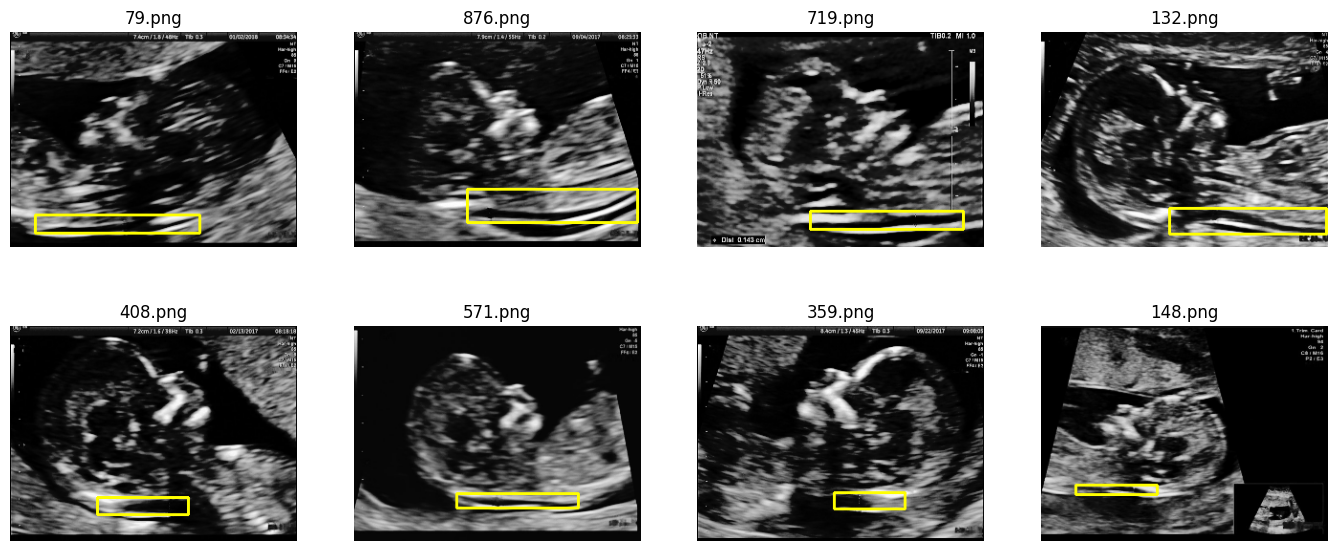

In [7]:
random_indexes = random.sample(range(len(images)),8)

fig = plt.figure(figsize=(17,7))

for i,index in enumerate(random_indexes):

    w_min = bounding_boxes[index][1]
    h_min = bounding_boxes[index][0]
    w_max = bounding_boxes[index][3]
    h_max = bounding_boxes[index][2]
    
    img_rect = cv2.rectangle(images[index].copy(), (w_min, h_min), (w_max, h_max), (255, 255, 0), 2)
    
    ax = fig.add_subplot(2,4,i+1)
    ax.imshow(img_rect)
    ax.set_title(image_ids[index])
    ax.axis('off')
    


In [8]:
print('Cantidad de imágenes: ',np.shape(images))
print('Cantidad de bounding boxes: ',np.shape(bounding_boxes))

Cantidad de imágenes:  (1110, 225, 300, 3)
Cantidad de bounding boxes:  (1110, 4)


## I.1.2. Preprocesamiento de datos: normalización de imágenes y _bounding boxes_

Tanto las imágenes como las _bounding boxes_ son normalizadas para que el entrenamiento de la red aprenda adecuadamente los parámentros, y, a su vez, se reduzcan los tiempos de entrenamiento.

In [9]:
images_normalized = images / 255.0
bounding_boxes_normalized = bounding_boxes / np.array(images_normalized.shape[1:3] * 2)

## I.2. Split de datos para entrenamiento

Los datos son divididos de manera aleatoria en set de _training_ y _validation_. Las prorporciones son: 80-20.

train_x:  (888, 225, 300, 3)
train_y:  (888, 4)
val_x:  (222, 225, 300, 3)
val_y:  (222, 4)


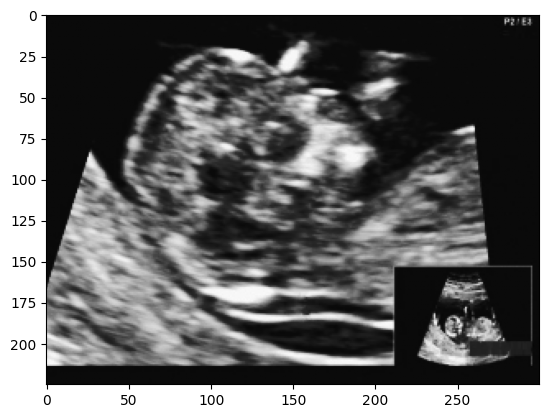

[0.75111111 0.36333333 0.83111111 0.70333333]


In [10]:
# Split the dataset
train_x, val_x, train_y, val_y = train_test_split(images_normalized, bounding_boxes_normalized, test_size=0.2)

# Dimensiones
print('train_x: ', np.shape(train_x))
print('train_y: ', np.shape(train_y))
print('val_x: ', np.shape(val_x))
print('val_y: ', np.shape(val_y))

# Corroboración - imágenes
plt.imshow(train_x[0], cmap='gray')
plt.show()

# Corroboración - bounding boxes
print(train_y[0])

## I.3.1. Definición del modelo

La red neuronal tendrá la tarea de aprender a asociar las estructuras en las imágenes correspondientes a TNs junto a su etiqueta que serán las coordeandas de los _bounding_boxes_, por lo tanto, la red entregará como resultado las coordenadas de lo que considere que son los límites de la translucencia nucal.

El modelo a entrenar utilizará de base el modelo VGG16 junto a los pesos asociados de 'Imagenet'. De esta modelo de base, se configurará para que todas sus capas puedan ser entrenables. Luego del modelo base, se utilizará una serie de tres capas profundas y densas, intercaladas con operaciones de Dropout. La capa de output consitirá en una capa de cuatro neuronas, las cuales entregarán las coordenadas de las _bounding_boxes_ predichas por el modelo.

In [11]:
# Define the model
def create_model(input_shape):
    vgg16 = VGG16(include_top=False, input_shape=input_shape)
    vgg16.trainable = True
    
    model = Sequential()
    model.add(vgg16)
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(4, activation='sigmoid'))
    
    return model

model = create_model(images[0].shape)

model.summary()    

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## I.3.2. Entrenamiento del modelo

- Métricas: se utilizará la métrica Mean Squared Error, debido a que la red debe devolver números (regresión) lo más parecidos posibles a aquuellos asociados a la etiqueta de las imágenes.

- Optimizador: Adam
- Learning Rate inicial: 1e-4
- Batchsize: 16
- Epochs: 50
- Callbacks: ReduceLROnPlateu y EarlyStopping

    Se optó un por _batchsize_ de poca magnitud por dos razones: por un lado, para garanzitar que la red adquiera un conocimiento más profundo de las estructuras de las imágenes; por otro lado, el dataset cuenta con un tamaño reducido, por lo que colocar tamañas de _batchsize_ mayores podrá perjudicar el entrenamiento del modelo.

In [12]:
# Train the model
lr = 1e-4
checkpoint = ModelCheckpoint('model2.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

model.compile(optimizer=Adam(learning_rate=lr), loss=MeanSquaredError(), metrics=[MeanSquaredError()])
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=16, epochs=50, callbacks=[checkpoint,rlrop,early_stopping])

Epoch 1/50


I0000 00:00:1733610437.420166     100 service.cc:145] XLA service 0x7f0560014680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733610437.420255     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733610437.420262     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1733610478.367975     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - learning_rate: 1.0000e-04
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - learning_rate: 1.0000e-04
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 378ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0093 - val_mean_squared_error: 0.0093 - learning_rate: 1.0000e-04
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - learning_rate: 1.0000e-04
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - loss: 0.0034 - mean_squared_error: 0.0033 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - learning_rate: 1.0000e-04
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0034 - val_mean_s

In [13]:
model.save('lukimodel.h5')

## I.4.1. Resultados: visualización de la métrica MSE

El entrenamiento del modelo arroja los siguientes resultados:

- MSE training: 7.9338e-4
- MSE validation: 0.0021

Esta métrica indica que la red ha logrado comprender con bastante precisión la ubicación de las _bounding boxes_ de las TNs. Es importante recalcar que, tanto el MSE del training como del validation son similares entre sí, por lo que es posible afirmar que la regularización propuesta en el modelo dió buenos resultados.

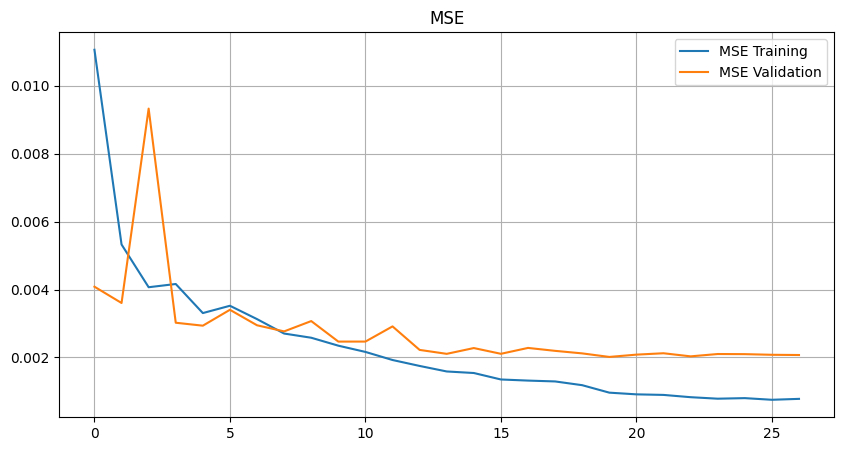

In [14]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,1,1)
ax.plot(history.history['mean_squared_error'],label='MSE Training')
ax.plot(history.history['val_mean_squared_error'],label='MSE Validation')
ax.set_title('MSE')
ax.legend()
ax.grid()
plt.show()

## I.4.2. Resultados: comparación visual de _bounding boxes_

La intención a continuación es visualizar efectivamente si la red ha podido predecir _bounding boxes_ coherentes.

In [15]:
def compare_segmentations(model: Model, img: np.ndarray, bounding_box: np.ndarray) -> float:
    """
    Side by side plot comparing original bounding box and the predicted one,
    by resizing the model output to original image size and superimposing
    :param model: regression model
    :param img: original image 
    :param bounding_box: origina bounding box
    :return: mean squared error 
    """
    bounding_box = bounding_box.copy()
    img = img.copy()

    rescaling_arr = np.array(img.shape[:2] * 2)
    
    pred = model.predict(np.array([img]))[0]
    pred *= rescaling_arr
    bounding_box *= rescaling_arr

    mse = np.mean((bounding_box - pred) ** 2)

    bounding_box = np.int32(bounding_box)
    pred = np.int32(pred)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    img_with_bb = cv2.rectangle(img.copy(), (int(bounding_box[1]), int(bounding_box[0])), (int(bounding_box[3]), int(bounding_box[2])), (255, 255, 0), 2)
    img_with_pred_bb = cv2.rectangle(img.copy(), (int(pred[1]), int(pred[0])), (int(pred[3]), int(pred[2])), (0, 255, 0), 2)
    axs[0].imshow(img_with_bb)
    axs[0].axis('off')
    axs[0].set_title('Original bounding box')
    axs[1].imshow(img_with_pred_bb)
    axs[1].axis('off')
    axs[1].set_title('Predicted bounding box')
    plt.show()
    
    return mse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


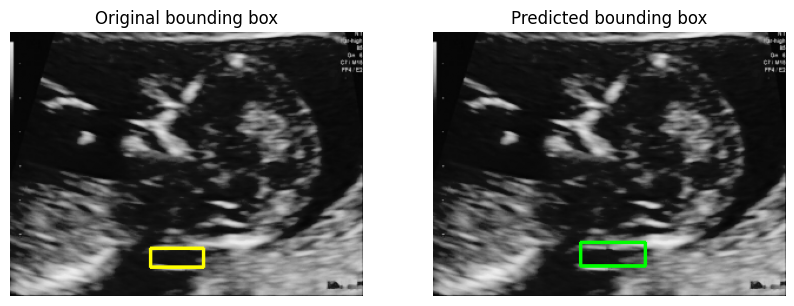

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


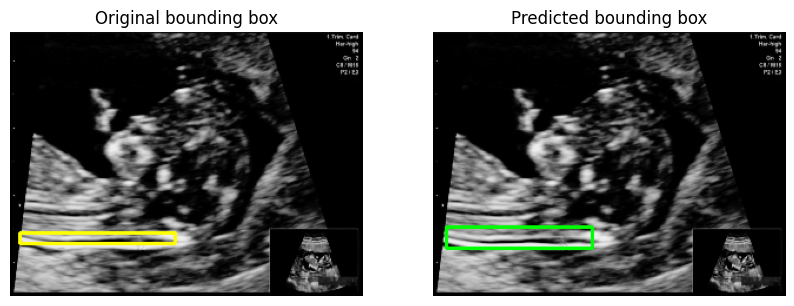

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


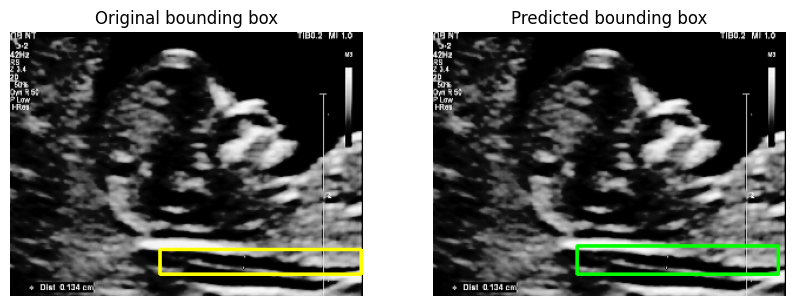

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


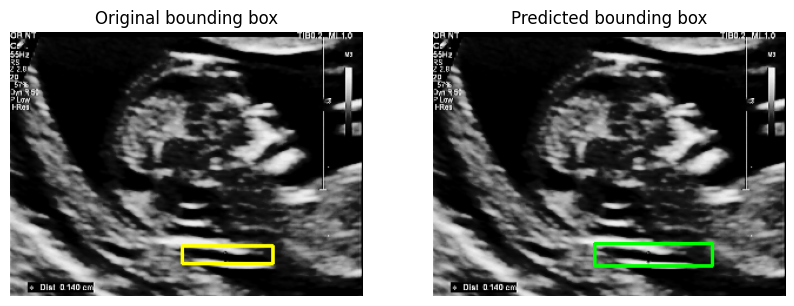

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


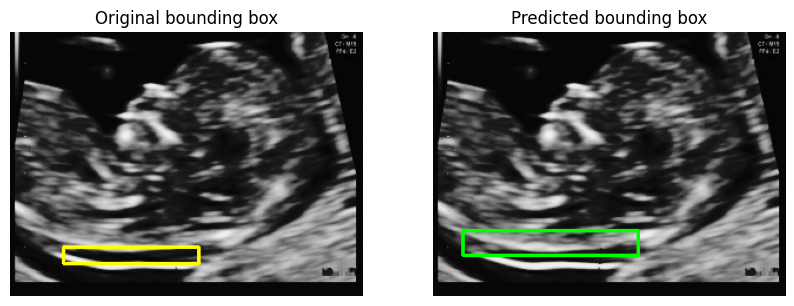

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


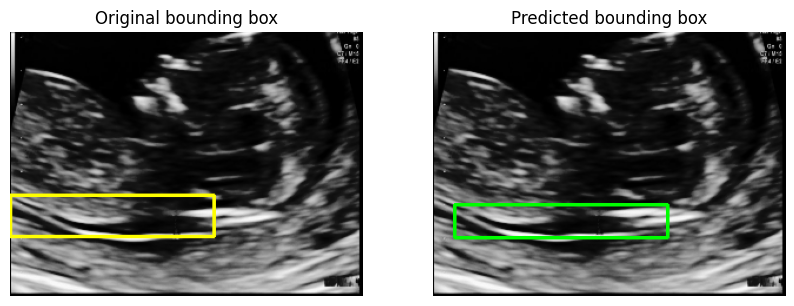

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


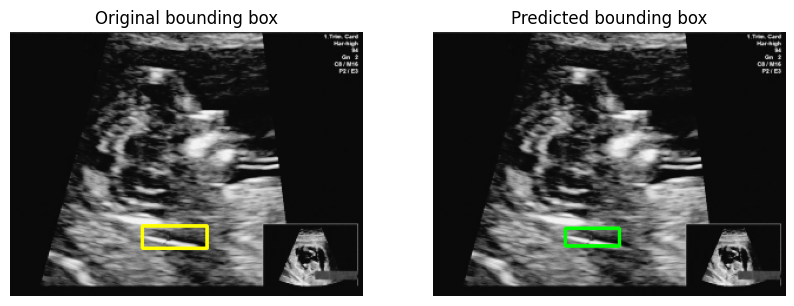

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


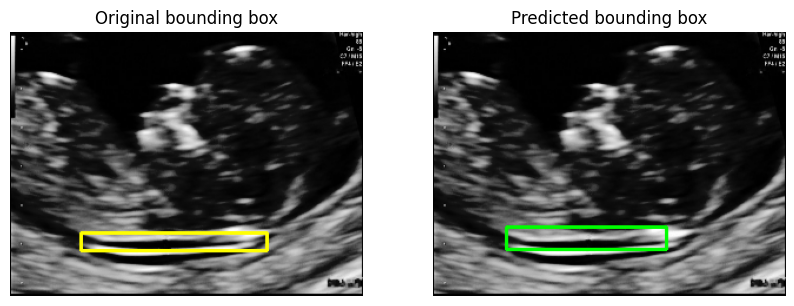

In [17]:
random_indexes_val = random.sample(range(len(val_x)),8)

# Compare segmentation
for index in random_indexes_val:
    compare_segmentations(model, val_x[index], val_y[index])

## I.5. Conclusiones del entrenamiento para identificación

A partir de la visualización de la ubicación de los _bounding boxes_ predichos por la red es posible afimar que la red ha adquirido la capacidad de ubicar adecuadamente la ubicación espacial de las TNs. Si bien los límites de de las TNs no siempre se corresponden con los valores veraderos, es importante mencionar que en todas las predicciones siempre gran parte de la TNs queda encerrada por los _bounding boxes_ predichos por la red.

Celebramos esta capacidad de la red para aprender a identificar con una buena aproximación inicial la ubicación de las TNs. Por otro lado, consideramos como trabajo a futuro la posibilidad de entrenar la red con otra arquitectura de capas densas y/o hiperparámetros que permitan obtener valores de MSE aún más bajos en la etapa de validation.